<a href="https://colab.research.google.com/github/fressbish/Koptev-Dmitry/blob/main/Lab5_KoptevDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

В данной работе мы с вами попробуем применить рекуррентные сети к задаче предсказания цены акций компании Microsoft.

В данном ноутбуке вы найдете частично готовый к применению код, некоторые элементы которого пропущены и вместо них стоит заглушка "\<ENTER YOUR CODE HERE>". Это означает, что вместо этой заглушки вам необходимо написать собственный код, решающий какую-то конкретную подзадачу. Детали вы найдете в комментариях около каждого из таких мест.
    
Давайте убедимся, что у нас установлены все необходимые библиотеки.

In [1]:
!pip install numpy matplotlib tensorflow

Для воспроизводимости зафиксируем генераторы случайных чисел.

In [2]:
seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Импортируем все необходимые библиотеки.

In [3]:
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Для начала нам необходимо прочитать набор данных. Вместе с данным ноутбуком вы найдете файл MSFT_corrupted.csv. Прочитайте и запишите его в фрейм.

In [4]:
df_dirty = pd.read_csv('MSFT_corrupted.csv')

Давайте выведем первые несколько строк файла.

In [5]:
df_dirty.head()

,date,open,high,low,close,volume,Name
0,2015-11-18,53.00,53.98,52.9799,53.85,29710030,MSFT
1,2015-11-19,53.99,54.66,53.7810,53.94,28149228,MSFT
2,2015-11-20,54.25,54.30,53.2650,54.19,37147608,MSFT
3,2015-11-23,54.25,54.46,53.7500,54.19,28235918,MSFT
4,2015-11-24,53.92,54.44,53.5800,54.25,24600043,MSFT


In [6]:
df_dirty.shape

(559, 7)

Судя по названию файла, в нем могут присутствовать проблемы с данными. Давайте проверим данные на наличие NaN и каким-либо образом восстановим пропущенные значения.

In [7]:
print(df_dirty.isnull().sum())   # Смотрим, есть ли NaN

date      0
open      5
high      5
low       5
close     5
volume    0
Name      0
dtype: int64


In [9]:
df = df_dirty.dropna()     # Если есть - избавляемся от них.

В данной работе мы с вами будем предсказывать стоимость акции на момент закрытия дня (колонка 'close'). Давайте построим график этой колонки.

<Axes: >

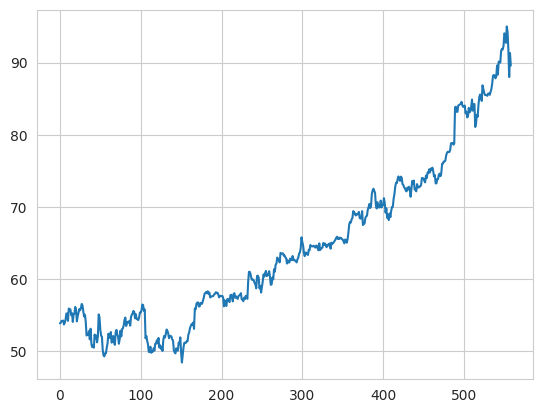

In [10]:
df['close'].plot()

Оставим в нашем датафрейме только необходимую нам колонку.

In [53]:
train_df = df[['close']]

Итак, теперь давайте подготовим все необходимое для начала обучения. Зададим глобальные константы - количества эпох, дней и коэффициент деления массива.

In [54]:
EPOCHS = 10  # количество эпох для обучения
DAYS = 10    # на сколько дней назад смотреть при обучении
SPLIT_VALUE = 0.95  # как делить массив

Определим константу для разделения массива на тренировочную и тестовую части.

In [55]:
training_data_len = int(len(train_df) * SPLIT_VALUE)
training_data_len

526

Далее с помощью MinMaxScaler'а приведем данные к значениям на отрезке \[0, 1]

In [56]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df)

Давайте создадим тренировочный набор данных. Набор будет выглядеть следующим образом: мы будем брать данные за последние X дней и формировать из этого вектор X, а вектор Y будет являться значением стоимости акции на следующий день

In [57]:
train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = []

for i in range(DAYS, len(train_data)):
    x_train.append(train_data[i-DAYS:i])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

Создадим модель для предсказания. Первым слоем модели должен являться рекуррентный слой с соответствующей формой входного тензора, последним - полносвязный слой с единственным нейроном для предсказания результата.

In [58]:
model = Sequential([
  LSTM(units=50, input_shape=(DAYS, 1)),
  Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS)

Epoch 1/10
516/516 [==============================] - 5s 5ms/step - loss: 0.0033
Epoch 2/10
516/516 [==============================] - 2s 5ms/step - loss: 9.7813e-04
Epoch 3/10
516/516 [==============================] - 3s 6ms/step - loss: 9.1438e-04
Epoch 4/10
516/516 [==============================] - 4s 9ms/step - loss: 6.5350e-04
Epoch 5/10
516/516 [==============================] - 4s 7ms/step - loss: 5.9592e-04
Epoch 6/10
516/516 [==============================] - 3s 7ms/step - loss: 6.2954e-04
Epoch 7/10
516/516 [==============================] - 5s 10ms/step - loss: 5.8121e-04
Epoch 8/10
516/516 [==============================] - 5s 10ms/step - loss: 5.1466e-04
Epoch 9/10
516/516 [==============================] - 4s 7ms/step - loss: 4.5660e-04
Epoch 10/10
516/516 [==============================] - 4s 8ms/step - loss: 4.8282e-04


Для тестирования нашей модели давайте таким же образом сформируем тестовый датасет.

In [60]:
test_data = scaled_data[training_data_len - DAYS: , :]

x_test = []
y_test = []
for i in range(DAYS, len(test_data)):
    x_test.append(test_data[i-DAYS:i])
    y_test.append(test_data[i, 0])

Давайте получим предсказания модели и визуализируем результат.

In [61]:
predictions = model.predict(np.array(x_test))

1/1 [==============================] - 1s 663ms/step


<ipython-input-62-6ddbfb5d4f3b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = scaler.inverse_transform(predictions)


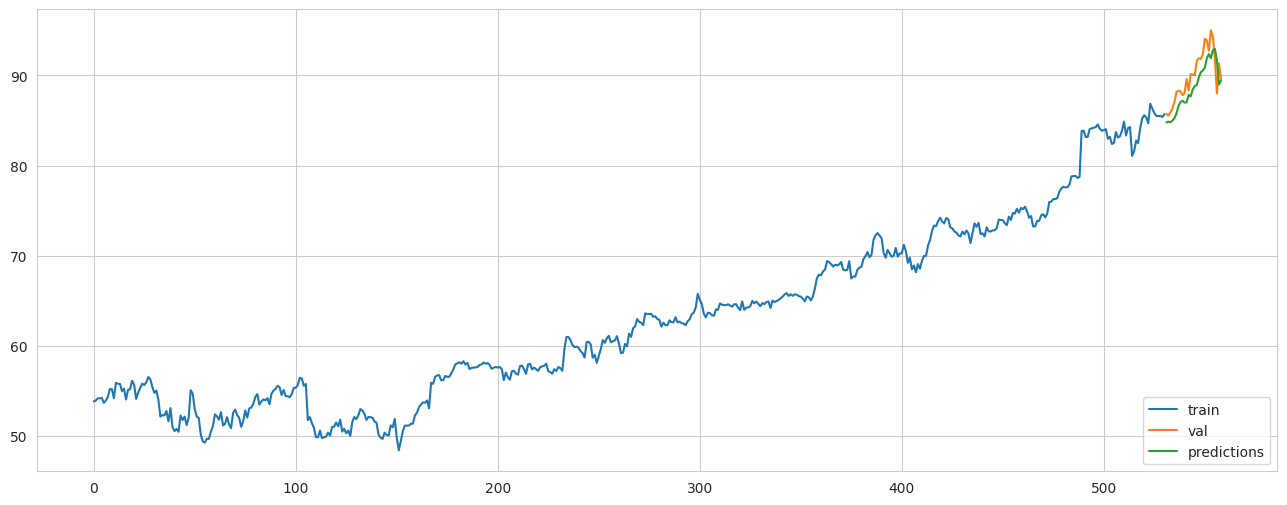

In [62]:
train = train_df[:training_data_len]
valid = train_df[training_data_len:]
valid['predictions'] = scaler.inverse_transform(predictions)
plt.figure(figsize=(16,6))
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['train', 'val', 'predictions'], loc='lower right')

В качестве бейзлайна (т.е. базовой просто модели для сравнения) выберем step-1 модель. Данная модель для дня i просто берет значение дня i-1. Реализуйте такую модель и в массив prediction_step запишите ее результаты для тех же данных.

In [63]:
predictions_step = np.array(train_df[training_data_len-1:-1])

In [64]:
assert predictions.shape == predictions_step.shape

Построим график нашей модели и step-1 модели.

<ipython-input-65-15a7b2d06abb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions_step'] = predictions_step


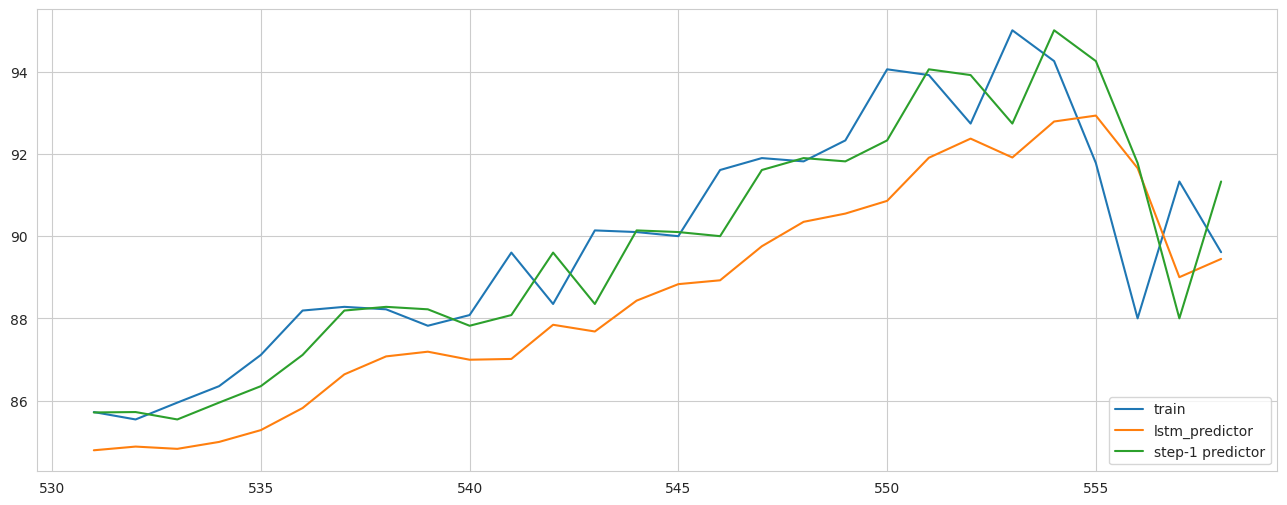

In [65]:
valid['predictions_step'] = predictions_step
plt.figure(figsize=(16,6))
plt.plot(valid[['close', 'predictions', 'predictions_step']])
plt.legend(['train', 'lstm_predictor', 'step-1 predictor'], loc='lower right')

Удалось ли вам добиться хороших результатов модели? Попробуйте поменять модель нейронной сети, количество слоев, и другие гиперпараметры.  

В процессе тестирования нашей модели мы, тем не менее, использовали "настоящие" данные каждый день для предсказания следующего дня. Давайте попробуем предсказать `len(valid)` дней (т.е. столько же, какова длина массива тестирования) обладая лишь данными на момент дня начала тестирования.  

Т.е. каждый шаг алгоритму необходимо подавать данные за последние DAYS дней, получать его предсказание и записывать в массив с данными как результат дня $i$. На следующем шаге в качестве данных уже будут данные за последние DAYS-1 дней и день $i$, а результат будет записан в день $i+1$ и так далее. Конечным итогом станет то, что мы сможем предсказать движение акций на несколько дней вперед.

In [66]:
x_test_independent = x_test[0].reshape(1, DAYS, 1)    # взять данные за первый день тестового периода
for i in range(len(valid)):
    result = result = model.predict(x_test_independent[:, -DAYS:, :])    # Получить предсказание модели на данных
    x_test_independent = np.concatenate((x_test_independent, result.reshape(1, 1, 1)), axis=1)  # Добавить полученный result в конец массива x_test_independent, т.о. он будет использован в следующий раз

1/1 [==============================] - 0s 22ms/step


Давайте построим график и посмотрим на результат, а также сравним его с результатом, когда нам известна настоящая информация за указанные дни.

<ipython-input-67-028c770c8d98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions_indep'] = scaler.inverse_transform(x_test_independent.reshape((-1, 1)))[-len(valid):]


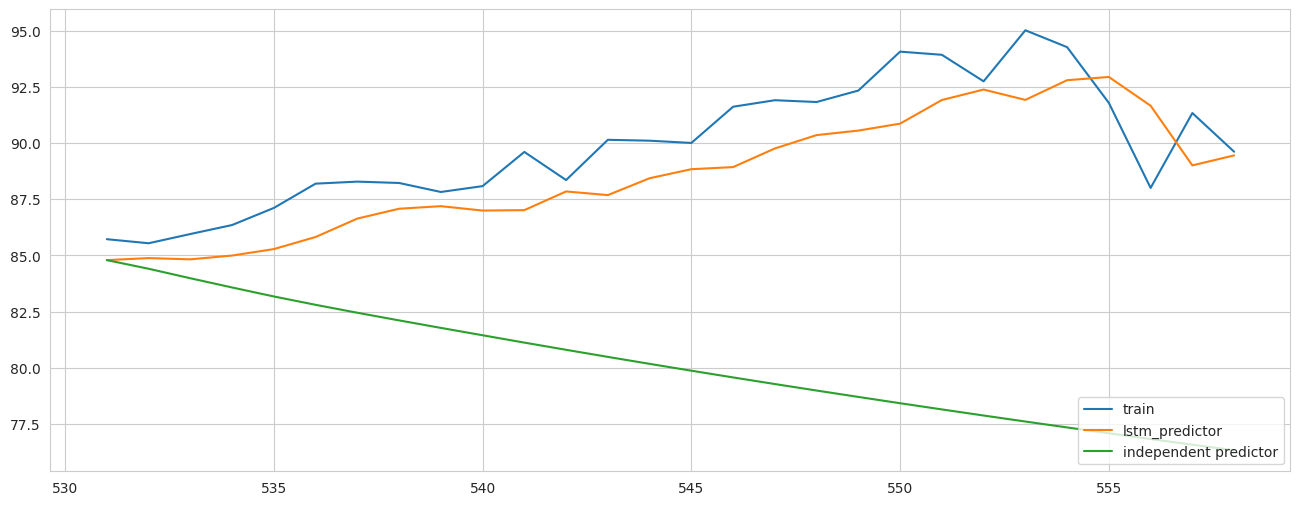

In [67]:
valid['predictions_indep'] = scaler.inverse_transform(x_test_independent.reshape((-1, 1)))[-len(valid):]
plt.figure(figsize=(16,6))
plt.plot(valid[['close', 'predictions', 'predictions_indep']])
plt.legend(['train', 'lstm_predictor', 'independent predictor'], loc='lower right')

Как можно заметить, результат оставляет желать лучшего. Рекуррентные модели склонны не учитывать тренд и фиксироваться на какой-либо точке.  

Вашим дальнейшим заданием будет следующее.  
В процессе анализа стоимости акций важным параметром является Moving Average - средняя стоимость акций за последние N дней. Вам необходимо вычислить MA за последние 7, 14 и 28 дней и добавить их как отдельные столбцы к тренировочным данным. После чего - натренировать новую нейронную сеть, которая будет получать MA 7, 14, 28 как входные данные и пытаться предсказывать их значения.

В конце точно так же сравните полученный результат с step-1 моделью и попробуйте построить предсказания из единственной точки. Сможет ли Moving Average исправить проблемы тренда за счет более гладких и усредненных результатов?

In [136]:
train_ma = pd.DataFrame()
train_ma['MA7']  = train_df['close'].rolling(window=7).mean()
train_ma['MA14'] = train_df['close'].rolling(window=14).mean()
train_ma['MA28'] = train_df['close'].rolling(window=28).mean()
# убираем пропуски
train_ma = train_ma.dropna()

In [137]:
train_ma.head()

,MA7,MA14,MA28
27,55.471429,55.341429,54.975357
28,55.782857,55.436429,55.063214
29,55.875714,55.451429,55.118214
30,55.797143,55.504286,55.140000
31,55.687143,55.497857,55.170714


In [138]:
EPOCHS = 10  # количество эпох для обучения
DAYS = 10    # на сколько дней назад смотреть при обучении
SPLIT_VALUE = 0.95  # как делить массив

In [139]:
training_data_len = int(len(train_ma) * SPLIT_VALUE)
training_data_len

500

In [140]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_ma)

train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = []

for i in range(DAYS, len(train_data)):
    x_train.append(train_data[i-DAYS:i])
    y_train.append(train_data[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)

In [141]:
model = tf.keras.Sequential([
  LSTM(units=50, input_shape=(DAYS, 3)),
  Dense(units=3)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [142]:
model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS)

Epoch 1/10
490/490 [==============================] - 5s 4ms/step - loss: 0.0044
Epoch 2/10
490/490 [==============================] - 3s 5ms/step - loss: 5.7472e-04
Epoch 3/10
490/490 [==============================] - 6s 11ms/step - loss: 4.0013e-04
Epoch 4/10
490/490 [==============================] - 3s 7ms/step - loss: 3.5221e-04
Epoch 5/10
490/490 [==============================] - 2s 5ms/step - loss: 3.5227e-04
Epoch 6/10
490/490 [==============================] - 2s 5ms/step - loss: 2.5473e-04
Epoch 7/10
490/490 [==============================] - 2s 5ms/step - loss: 2.1621e-04
Epoch 8/10
490/490 [==============================] - 4s 7ms/step - loss: 2.1516e-04
Epoch 9/10
490/490 [==============================] - 2s 5ms/step - loss: 1.5200e-04
Epoch 10/10
490/490 [==============================] - 2s 4ms/step - loss: 1.8759e-04


In [143]:
test_data = scaled_data[training_data_len - DAYS: , :]

x_test = []
y_test = []
for i in range(DAYS, len(test_data)):
    x_test.append(test_data[i-DAYS:i])
    y_test.append(test_data[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
preds = model.predict(x_test)

1/1 [==============================] - 1s 812ms/step


In [144]:
train = train_ma[:training_data_len]
val = train_ma[training_data_len:]
val[['preds7', 'preds14', 'preds28']] = scaler.inverse_transform(preds)

<ipython-input-144-28df420627f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[['preds7', 'preds14', 'preds28']] = scaler.inverse_transform(preds)
<ipython-input-144-28df420627f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[['preds7', 'preds14', 'preds28']] = scaler.inverse_transform(preds)
<ipython-input-144-28df420627f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

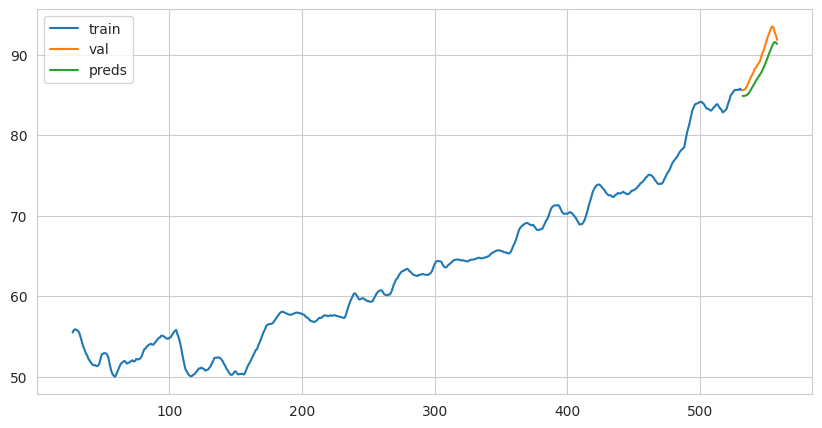

In [146]:
plt.figure(figsize=(10,5))
plt.plot(train['MA7'])
plt.plot(val[['MA7', 'preds7']])
plt.legend(['train', 'val', 'preds'])

plt.show()

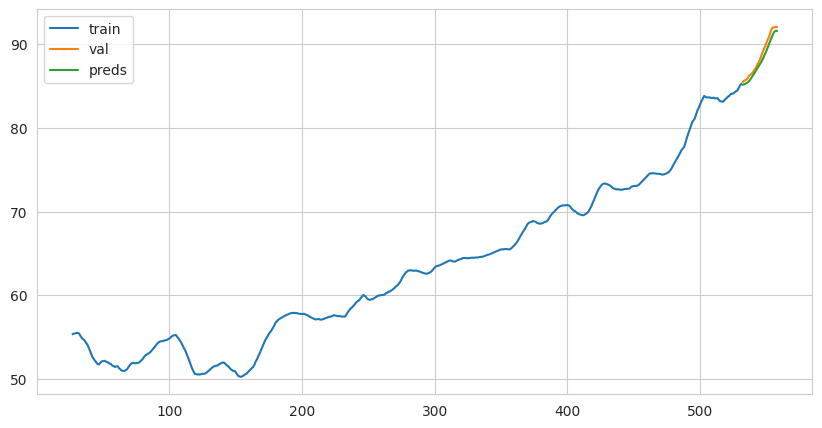

In [147]:
plt.figure(figsize=(10,5))
plt.plot(train['MA14'])
plt.plot(val[['MA14', 'preds14']])
plt.legend(['train', 'val', 'preds'])

plt.show()

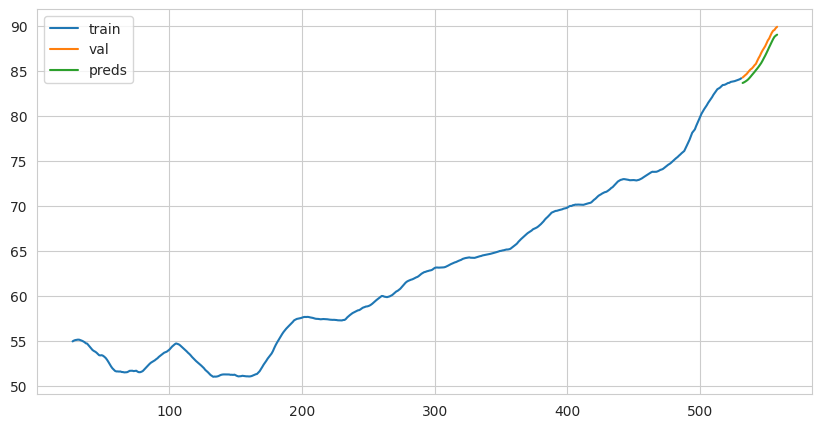

In [148]:
plt.figure(figsize=(10,5))
plt.plot(train['MA28'])
plt.plot(val[['MA28', 'preds28']])
plt.legend(['train', 'val', 'preds'])

plt.show()

In [149]:
# Сравним со step-1

val['preds_step_7']  = np.array(train_ma['MA7'][training_data_len-1:-1])
val['preds_step_14'] = np.array(train_ma['MA14'][training_data_len-1:-1])
val['preds_step_28'] = np.array(train_ma['MA28'][training_data_len-1:-1])

<ipython-input-149-35a8e2ecb527>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['preds_step_7']  = np.array(train_ma['MA7'][training_data_len-1:-1])
<ipython-input-149-35a8e2ecb527>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['preds_step_14'] = np.array(train_ma['MA14'][training_data_len-1:-1])
<ipython-input-149-35a8e2ecb527>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

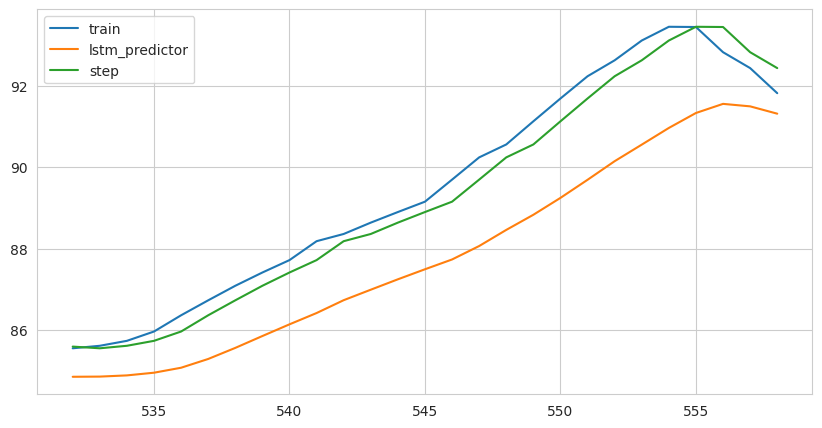

In [150]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA7', 'preds7', 'preds_step_7']])
plt.legend(['train', 'lstm_predictor', 'step'])

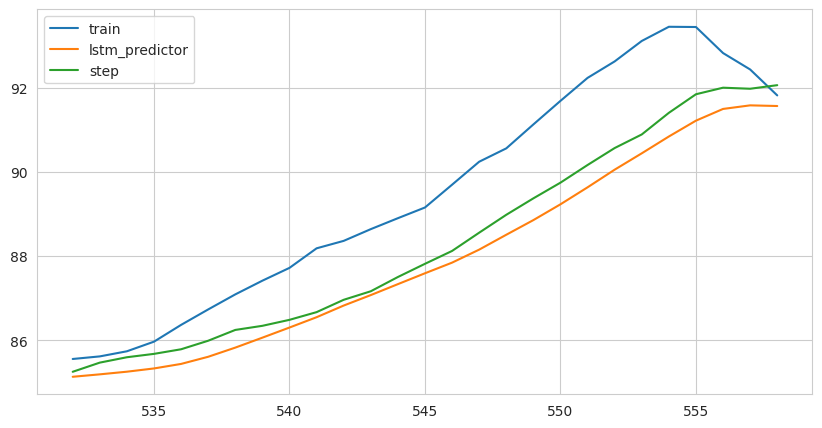

In [151]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA7', 'preds14', 'preds_step_14']])
plt.legend(['train', 'lstm_predictor', 'step'])

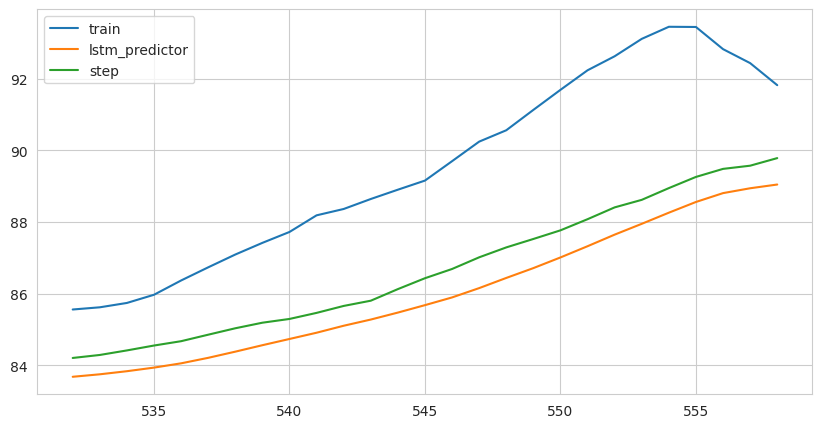

In [152]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA7', 'preds28', 'preds_step_28']])
plt.legend(['train', 'lstm_predictor', 'step'])

In [153]:
# Построим предсказания из единственной точки

x_test_independent = x_test[0].reshape(1, DAYS, 3)  # взять данные за первый день тестового периода
for i in range(len(val)):
    result = model.predict(x_test_independent[:, -DAYS:, :]) # Получить предсказание модели на данных
    x_test_independent = np.concatenate((x_test_independent, result.reshape(1, 1, 3)), axis=1)  # Добавить полученный result в конец массива x_test_independent, т.о. он будет использован в следующий раз

1/1 [==============================] - 0s 25ms/step


In [154]:
val.shape

(27, 9)

In [155]:
scaler.inverse_transform(x_test_independent.reshape((-1, 3)))[-len(valid):].shape

(28, 3)

<ipython-input-165-74f8ecf62109>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[['preds_idp_7', 'preds_idp_14', 'preds_idp_28']] = scaler.inverse_transform(x_test_independent.reshape((-1, 3)))[-len(val):]


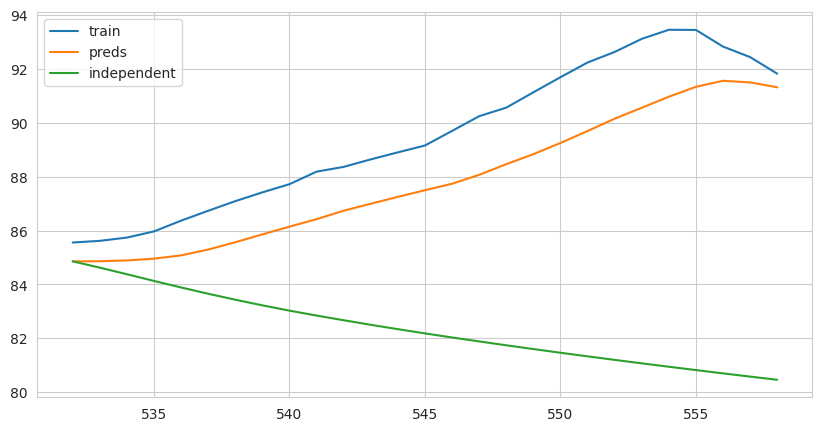

In [165]:
val[['preds_idp_7', 'preds_idp_14', 'preds_idp_28']] = scaler.inverse_transform(x_test_independent.reshape((-1, 3)))[-len(val):]

plt.figure(figsize=(10,5))
plt.plot(val[['MA7', 'preds7', 'preds_idp_7']])
plt.legend(['train', 'preds', 'independent'])
plt.show()

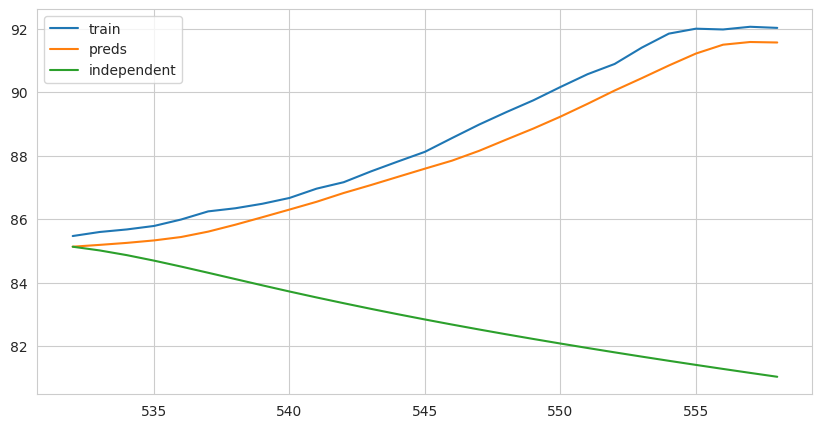

In [166]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA14', 'preds14', 'preds_idp_14']])
plt.legend(['train', 'preds', 'independent'])
plt.show()

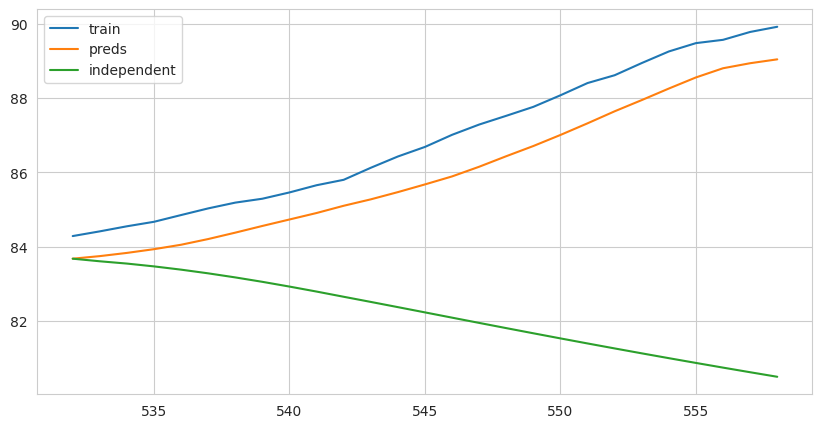

In [168]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA28', 'preds28', 'preds_idp_28']])
plt.legend(['train', 'preds', 'independent'])
plt.show()